In [1]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.

torch.cuda.empty_cache()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [3]:
path = "aptos2019-blindness-detection/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


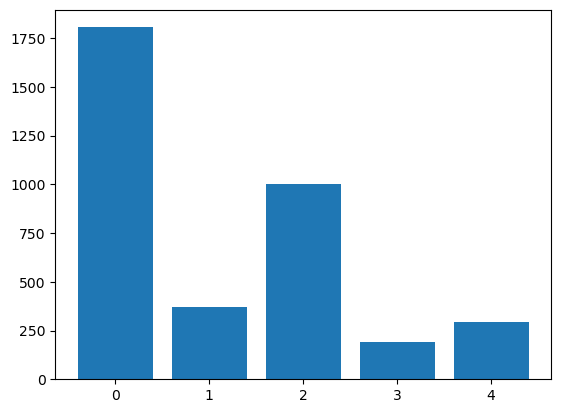

In [4]:
bins = np.arange(-0.5, max(train_df.diagnosis) + 1.5, 1)

# Plot histogram with adjusted bins
plt.hist(train_df.diagnosis, bins=bins, rwidth=0.8, align='mid')

# Set x-ticks to be at the center of each bar
plt.xticks(np.arange(0, 5, 1))

# Turn off the grid or adjust it
plt.grid(False)

# Show the plot
plt.show()

In [5]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights) #Prints the calculated weights for the classes.

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


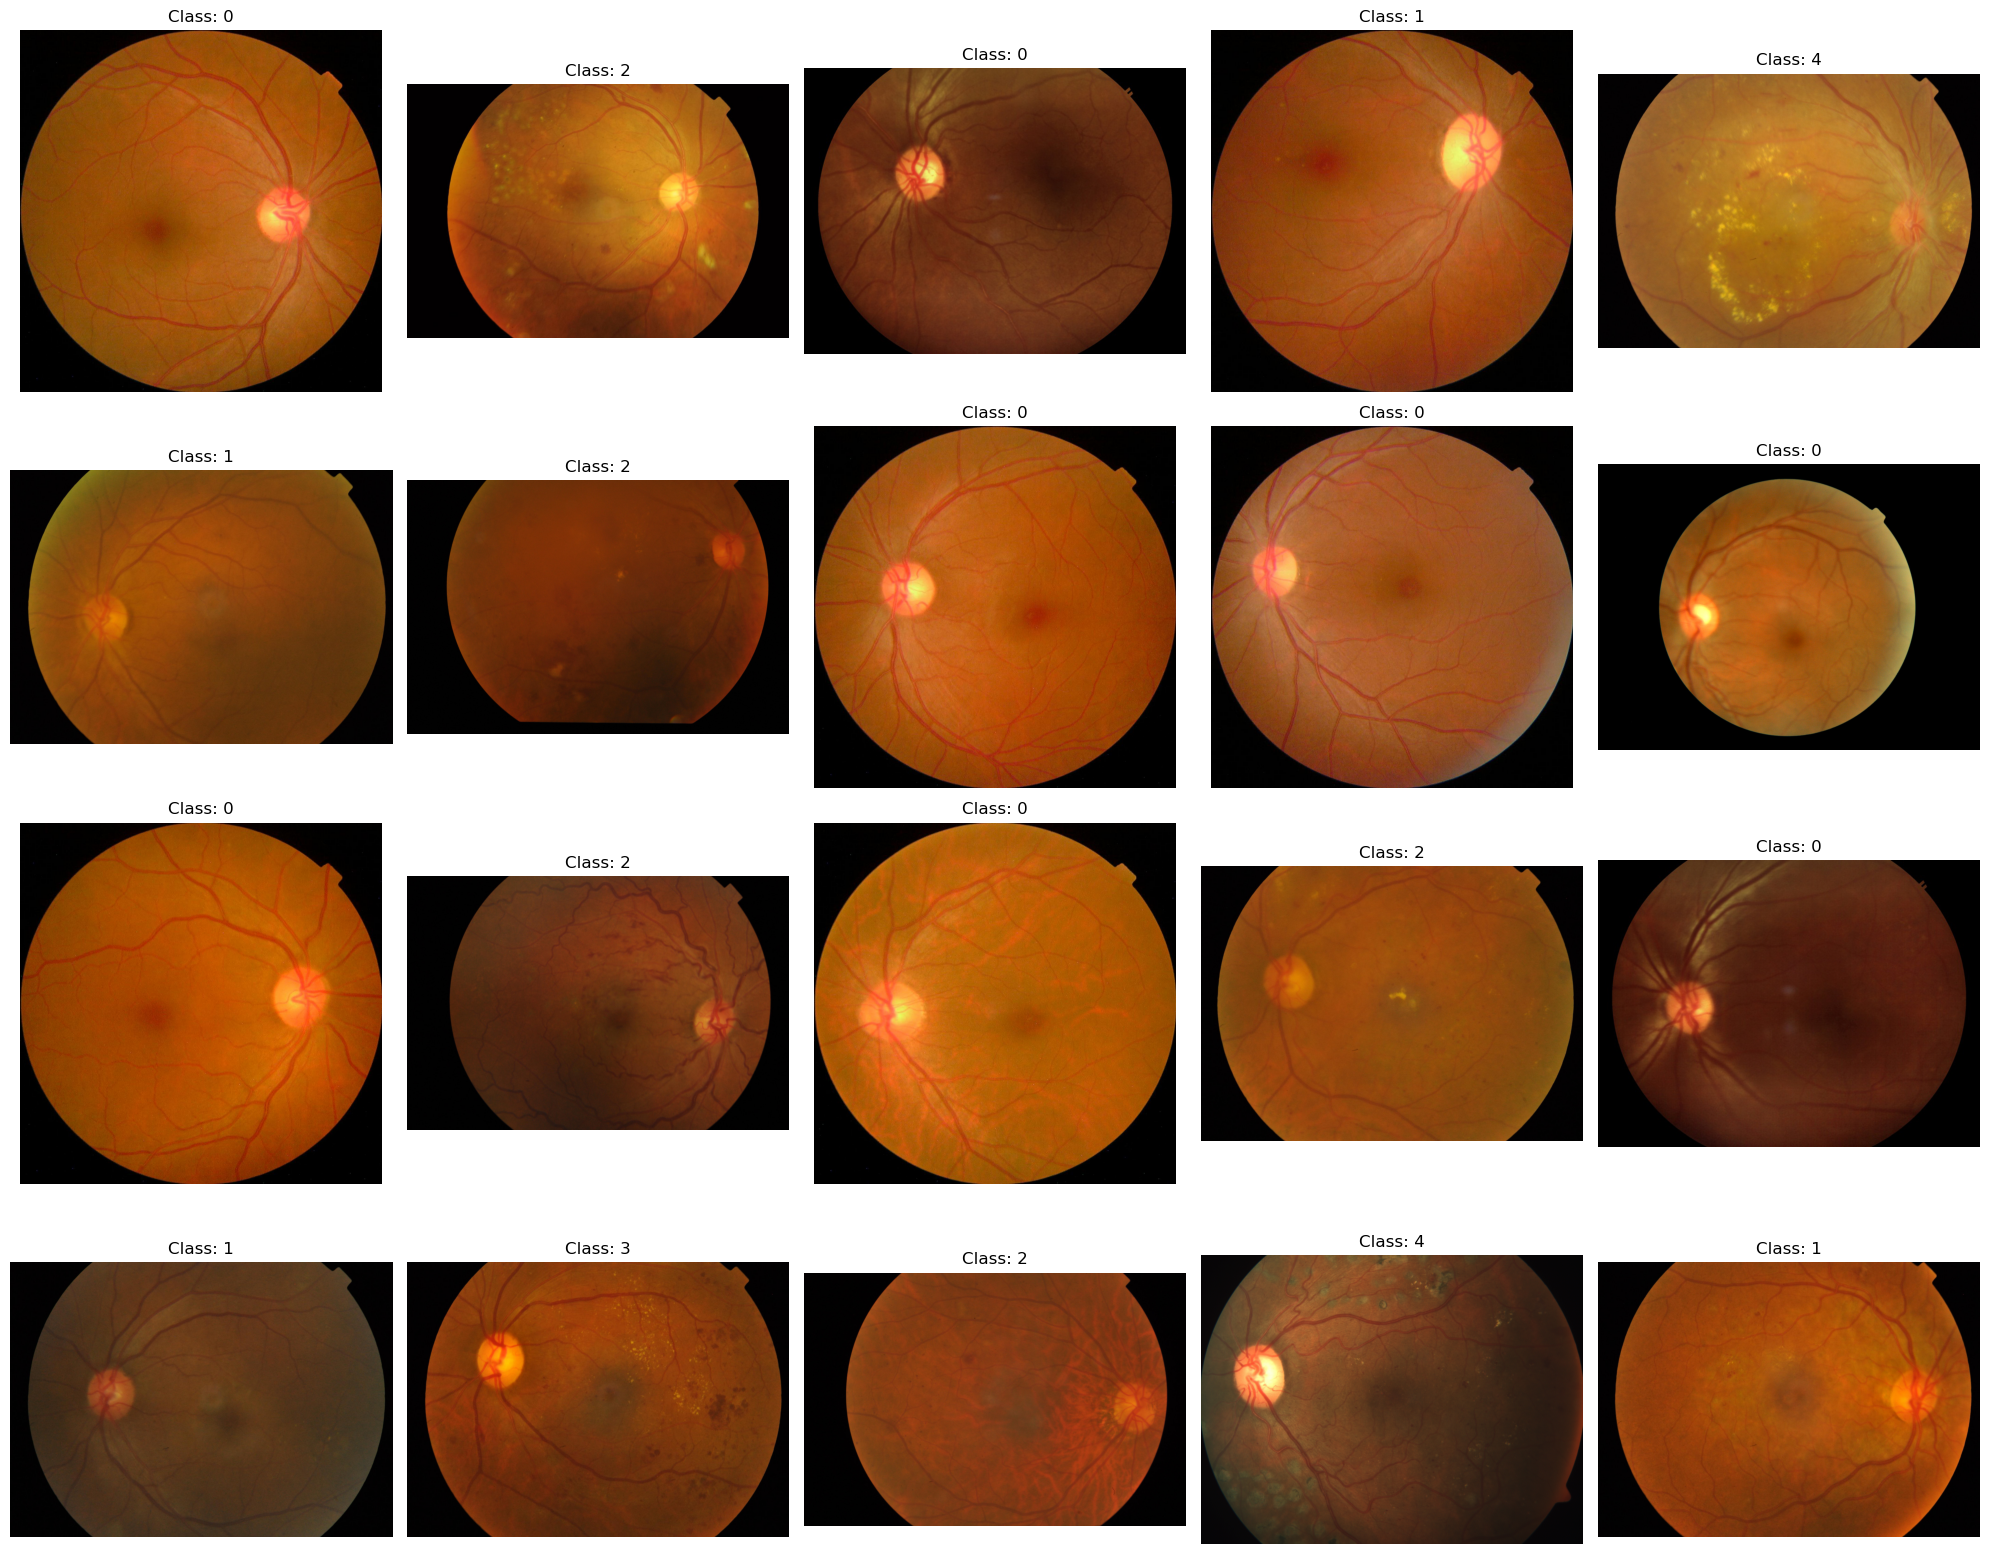

In [6]:
# Set the number of images to display
num_images = 20

# Generate a list of random indices based on the DataFrame length
random_indices = np.random.randint(0, len(train_df), size=num_images)

# Set up the plot - adjust subplot grid as needed
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16)) # Adjust nrows and ncols based on num_images
axes = axes.flatten()

for i, ax in zip(random_indices, axes):
    # Construct the full path to the image
    sample_image_path = f'{path}train_images/{train_df["id_code"][i]}.png'
    sample_image = Image.open(sample_image_path)
    
    # Plotting
    ax.imshow(sample_image)
    ax.axis('off') # Hides the axis
    ax.set_title(f'Class: {train_df["diagnosis"][i]}') # Shows the class of each image

# Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.tight_layout()
plt.show()

In [7]:
class CustomCropAndResize:

    def __call__(self, img):
        # Convert image to grayscale for thresholding
        gray = img.convert('L')
        img_array = np.array(gray)

        # Thresholding to detect non-black areas
        threshold = 10
        non_black_coords = np.argwhere(img_array > threshold)
        
        if non_black_coords.size:
            # Calculate bounding box of non-black area
            ystart, xstart = non_black_coords.min(axis=0)
            ystop, xstop = non_black_coords.max(axis=0) + 1
            bbox = (xstart, ystart, xstop, ystop)
            cropped_image = img.crop(bbox)
            return cropped_image
        else:
            # Resize if no non-black area is found
            return img


In [8]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

In [9]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

In [11]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [12]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )

    def forward(self, x):
        return self.up(x)

In [13]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=5):
        super(AttentionUNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)

        self.up1 = UpConv(512, 256)
        self.att1 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.up_conv1 = DoubleConv(512, 256)

        self.up2 = UpConv(256, 128)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.up_conv2 = DoubleConv(256, 128)

        self.up3 = UpConv(128, 64)
        self.att3 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.up_conv3 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, out_channels)  # Assuming out_channels is your number of classes

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = F.max_pool2d(self.down1(x1), 2)
        x3 = F.max_pool2d(self.down2(x2), 2)
        x4 = F.max_pool2d(self.down3(x3), 2)

        # Decoder path
        x = self.up1(x4)
        g1 = self.att1(x, x3)
        x = self.up_conv1(torch.cat([x, g1], dim=1))

        x = self.up2(x)
        g2 = self.att2(x, x2)
        x = self.up_conv2(torch.cat([x, g2], dim=1))

        x = self.up3(x)
        g3 = self.att3(x, x1)
        x = self.up_conv3(torch.cat([x, g3], dim=1))

        x = self.global_avg_pool(x)  # Collapse spatial dimensions
        x = x.view(x.size(0), -1)  # Flatten
        logits = self.classifier(x)
        return logits

In [14]:
image_transform = transforms.Compose([CustomCropAndResize(),
                                      transforms.Resize([512, 512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_size = int(0.9 * len(data_set))
valid_size = len(data_set) - train_size

train_set, valid_set = torch.utils.data.random_split(data_set, [train_size, valid_size])

In [15]:
train_dataloader = DataLoader(train_set,batch_size=4,shuffle=True, num_workers=4) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=4,shuffle=False, num_workers=4) #DataLoader for validation_set.

In [16]:
model = AttentionUNet() 
model = model.to(device) #Moves the model to the device.

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Compute class weights and convert to tensor
class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'].values), dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 30
train_losses = []  # Store training losses
valid_losses = []  # Store validation losses
train_accuracies = []  # Store training accuracy
valid_accuracies = []  # Store validation accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-------------------------------')
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    training_loss = running_loss / len(train_dataloader)
    training_accuracy = 100 * train_correct / train_total
    train_losses.append(training_loss)  # Append the average training loss
    train_accuracies.append(training_accuracy)  # Append training accuracy

    # Validation phase
    model.eval()
    running_loss = 0.0
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    
    validation_loss = running_loss / len(valid_dataloader)
    validation_accuracy = 100 * valid_correct / valid_total
    valid_losses.append(validation_loss)  # Append the average validation loss
    valid_accuracies.append(validation_accuracy)  # Append validation accuracy

    print(f'Training Loss per batch = {training_loss:.6f}\tAccuracy on Training set = {training_accuracy:.6f}% [{train_correct}/{train_total}]')
    print(f'Validation Loss per batch = {validation_loss:.6f}\tAccuracy on Validation set = {validation_accuracy:.6f}% [{valid_correct}/{valid_total}]')

Epoch 1/30
-------------------------------
Training Loss per batch = 1.431723	Accuracy on Training set = 55.660091% [1834/3295]
Validation Loss per batch = 1.750558	Accuracy on Validation set = 49.318801% [181/367]
Epoch 2/30
-------------------------------
Training Loss per batch = 1.324841	Accuracy on Training set = 61.669196% [2032/3295]
Validation Loss per batch = 1.244683	Accuracy on Validation set = 63.487738% [233/367]
Epoch 3/30
-------------------------------
Training Loss per batch = 1.265907	Accuracy on Training set = 63.702580% [2099/3295]
Validation Loss per batch = 1.855386	Accuracy on Validation set = 32.152589% [118/367]
Epoch 4/30
-------------------------------
Training Loss per batch = 1.262948	Accuracy on Training set = 64.643399% [2130/3295]
Validation Loss per batch = 1.198596	Accuracy on Validation set = 64.850136% [238/367]
Epoch 5/30
-------------------------------
Training Loss per batch = 1.234701	Accuracy on Training set = 64.339909% [2120/3295]
Validation L

KeyboardInterrupt: 

In [ ]:
#Plot the graph of train_losses & valid_losses against num_epochs.
epochs = range(1, num_epochs + 1)  # Adjusted to match the epoch numbering
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Plot the graph of train_accuracies & valid_accuracies against num_epochs.
epochs = range(1, num_epochs + 1)  # Adjusted to match the epoch numbering
plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_set = dataset(test_df,f'{path}test_images',image_transform = image_transform,train = False )

test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False) #DataLoader for test_set.

In [ ]:
def test(dataloader,model):
    '''
    test function predicts the labels given an image batches.
    
    Args :
         dataloader: DataLoader for the test_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         
    Returns :
         List of predicted labels.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    labels = [] #List to store the predicted labels.
    
    with torch.no_grad():
        
        for batch,x in enumerate(dataloader):
            
            output = model(x.to(device))
            
            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.
            labels.extend(predictions)
                
    print('Testing has completed')
            
    return labels                

In [ ]:
labels = test(test_dataloader,model) #Calls the test function.

In [ ]:
print(labels)